In [1]:
#%pip install yfinance
#%pip install pmdarima

In [2]:
# For data manipulation
import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from dtaidistance import dtw
from scipy.signal import correlate
import pmdarima as pm

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# Fetch historical data for XAUUSD (2000 hourly bars)
forex_data_hour = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                              interval=Interval.in_15_minute, n_bars=4000)

prices = forex_data_hour['close']
prices

datetime
2024-09-02 11:30:00    2505.33
2024-09-02 11:45:00    2506.35
2024-09-02 12:00:00    2502.88
2024-09-02 12:15:00    2501.08
2024-09-02 12:30:00    2499.94
                        ...   
2024-10-31 22:30:00    2745.52
2024-10-31 22:45:00    2743.77
2024-11-01 00:00:00    2747.17
2024-11-01 00:15:00    2746.00
2024-11-01 00:30:00    2745.96
Name: close, Length: 4000, dtype: float64

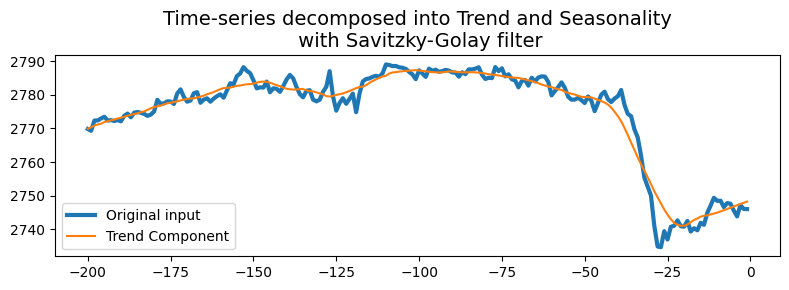

In [3]:
# Save the original time index
original_time_index = prices.index

# Reset the index to 0 to 999
prices = prices.reset_index(drop=True)

yvalues = prices
yvalues_trend = savgol_filter(yvalues,19,1)
yvalues_seasonal = yvalues-yvalues_trend

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-200,0), yvalues[-200:], label='Original input',linewidth=3)
ax.plot(np.arange(-200,0), yvalues_trend[-200:], label='Trend Component')
#ax.plot(yvalues_seasonal, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.tight_layout()
plt.show()


In [10]:
# Definition of Forecast Parameters
forecast_elements = 24

# Trend - fit stepwise auto-ARIMA
smodel = pm.auto_arima(yvalues_trend, start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=4,
                         start_P=0, seasonal=False,
                         d=None, D=0, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
smodel.summary()

forecast = smodel.predict(n_periods=forecast_elements)

# Extend trend forecast
yvalues_trend_forecast = np.concatenate((yvalues_trend, forecast))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3516.240, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5128.077, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3509.877, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1357.524, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5197.105, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3551.046, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3516.967, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3550.666, Time=1.85 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3550.709, Time=1.78 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3521.109, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3521.495, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3514.710, Time=1.45 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3549.995, Time=0.58 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 7.818 seconds


In [5]:
def fft_forecast(signal, forecast_elements, target_harmonics=40):

    # Perform FFT on the seasonal component
    N = len(signal)
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(N)

    # **2. Retain non-negative frequencies (including zero)**
    positive_freq_indices = fft_freq >= 0
    fft_freq_positive = fft_freq[positive_freq_indices]
    fft_result_positive = fft_result[positive_freq_indices]

    # Limit the number of harmonics
    num_harmonics = min(target_harmonics, len(fft_freq_positive))
    frequencies = fft_freq_positive[:num_harmonics]
    amplitudes = fft_result_positive[:num_harmonics]

    # **3. Create extended indices including future points**
    reconstructed_length = N + forecast_elements
    extended_indices = np.arange(reconstructed_length)

    # **4. Reconstruct the signal using the selected harmonics**
    reconstructed_signal = np.zeros(reconstructed_length)

    for i in range(num_harmonics):
        frequency = frequencies[i]
        amplitude_complex = amplitudes[i]
        amplitude = np.abs(amplitude_complex)
        phase = np.angle(amplitude_complex)
        omega = 2 * np.pi * frequency

        if frequency == 0:  # DC component
            reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
        else:
            reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)
    
    return reconstructed_signal, num_harmonics

In [11]:
# Definition of Forecast Parameters
validation_elements = 8
seasonal_harmonics_list = np.arange(40, 80, 5)
seasonal_input_elements_list = np.arange(200, 800, 5)
visualization_elements = 120

# Initialize a list to store results
results = []

# Define error metric: Root Mean Squared Error (RMSE)
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Generate forecasts by looping over different parameters
for seasonal_harmonics in seasonal_harmonics_list:
    for seasonal_input_elements in seasonal_input_elements_list:
        # Calculate starting index, and get input data slice
        start_idx = len(yvalues_seasonal) - validation_elements - seasonal_input_elements
        input_slice = yvalues_seasonal[start_idx:start_idx+seasonal_input_elements]

        # Generate forecast with FFT
        yvalues_seasonal_forecast, num_harmonics = fft_forecast(
            input_slice,
            validation_elements+forecast_elements,
            seasonal_harmonics
        )
        
        # Convert forecasts to numpy arrays if they're pandas Series
        if isinstance(yvalues_seasonal_forecast, pd.Series):
            yvalues_seasonal_forecast = yvalues_seasonal_forecast.to_numpy()
        if isinstance(yvalues_seasonal, pd.Series):
            yvalues_seasonal = yvalues_seasonal.to_numpy()

        # Extract validation and test portions
        actual_validation = yvalues_seasonal[-validation_elements:]
        forecast_validation = yvalues_seasonal_forecast[-validation_elements-forecast_elements:-forecast_elements]

        # Calculate distances
        validation_distance = dtw.distance(actual_validation, forecast_validation)

        # Calculate cross-correlation for validation set
        validation_cross_corr = correlate(actual_validation, 
                                            forecast_validation, 
                                            mode='full')
        validation_max_corr = max(validation_cross_corr)

        # Store the results
        results.append({
            'seasonal_input_length': seasonal_input_elements,
            'seasonal_harmonics': seasonal_harmonics,
            'rmse_validation': calculate_rmse(actual_validation, forecast_validation),
            'dtw_validation': validation_distance,
            'cc_validation': validation_max_corr,
        })

results_df = pd.DataFrame(results)
results_df.sort_values(by='dtw_validation', ascending=True).head(20)

,seasonal_input_length,seasonal_harmonics,rmse_validation,dtw_validation,cc_validation
657,485,65,2.346584,2.106763,27.743498
485,225,60,1.209913,2.179732,20.996515
776,480,70,1.786335,2.198907,27.499491
537,485,60,2.173003,2.199417,27.130167
725,225,70,1.220800,2.218847,21.818403
536,480,60,1.729291,2.224908,26.972531
605,225,65,1.411989,2.231067,20.834772
416,480,55,1.882523,2.251373,27.892447
417,485,55,2.096670,2.274477,26.158037
656,480,65,1.835050,2.274510,28.595431


In [32]:
# Define plot function
def plot_forecast(seasonal_input_elements, seasonal_harmonics, choice = 0):

    # Calculate starting index, and get input data slice
    start_idx = len(yvalues_seasonal) - validation_elements - seasonal_input_elements
    input_slice = yvalues_seasonal[start_idx:start_idx+seasonal_input_elements]

    # Generate forecast with FFT
    yvalues_seasonal_forecast, num_harmonics = fft_forecast(
        input_slice,
        validation_elements+forecast_elements,
        seasonal_harmonics
    )

    # Calculate slice indices
    len_original_slice = visualization_elements + validation_elements
    len_forecast_slice = visualization_elements + validation_elements + forecast_elements
    original_slice_idx_list = np.arange(-len_original_slice, 0)
    forecast_slice_idx_list = np.arange(-len_original_slice, forecast_elements)

    # Apply the helper function to each slice
    prices_slice = prices[-visualization_elements-validation_elements:]
    yvalues_trend_slice = yvalues_trend_forecast[-len_forecast_slice:]
    seasonal_original_slice = yvalues_seasonal[-visualization_elements-validation_elements:]
    seasonal_forecast_slice = yvalues_seasonal_forecast[-len_forecast_slice:]
    combined_forecast_slice = yvalues_trend_forecast[-len_forecast_slice:] + yvalues_seasonal_forecast[-len_forecast_slice:]

    # Get the last data time
    last_datetime = forex_data_hour.index[-1]
 
    # Plotting
    plt.figure(figsize=(12, 12))

    # Plot original price and trend
    plt.subplot(3, 1, 1)
    plt.plot(original_slice_idx_list/4, prices_slice, label="Original Price")
    plt.plot(forecast_slice_idx_list/4, yvalues_trend_slice, label='Trend Component', color='pink')
    plt.plot(forecast_slice_idx_list/4, combined_forecast_slice, label='Trend Component', color='green')
    plt.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
    plt.axvline(x=-validation_elements/4, color='orange', linestyle='--', label="Validation Start")
    plt.title(f"Original Prices - {last_datetime}")
    plt.xlabel("Hours")
    plt.ylabel("Prices")
    plt.grid(True)
    plt.legend()

    # Plot original and reconstructed seasonal
    plt.subplot(3, 1, 2)
    plt.plot(original_slice_idx_list/4, seasonal_original_slice, label="Original Seasonal", color='blue')
    plt.plot(forecast_slice_idx_list/4, seasonal_forecast_slice, label="Reconstructed Seasonal with Forecast", color='green')
    plt.axvline(x=-validation_elements/4, color='orange', linestyle='--', label="Validation Start")
    plt.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
    plt.axvline(x=validation_elements/4, color='violet', linestyle='--', label="70% Boundary")
    if choice != 0:
        plt.title(f"Original Seasonal vs Reconstructed Seasonal with Forecast ({seasonal_input_elements}, {seasonal_harmonics}) - Choice {choice}")
    else:
        plt.title(f"Original Seasonal vs Reconstructed Seasonal with Forecast ({seasonal_input_elements}, {seasonal_harmonics})")
    plt.xlabel("Hours")
    plt.ylabel("Prices")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

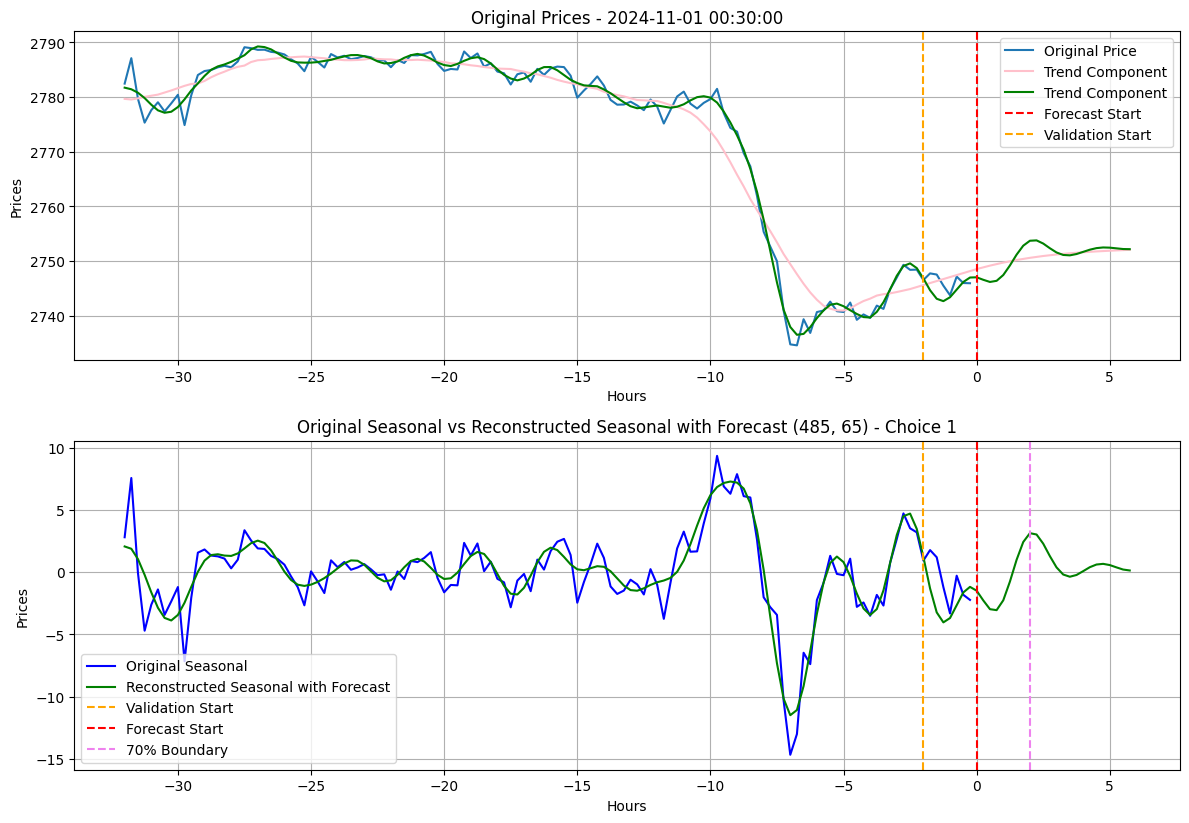

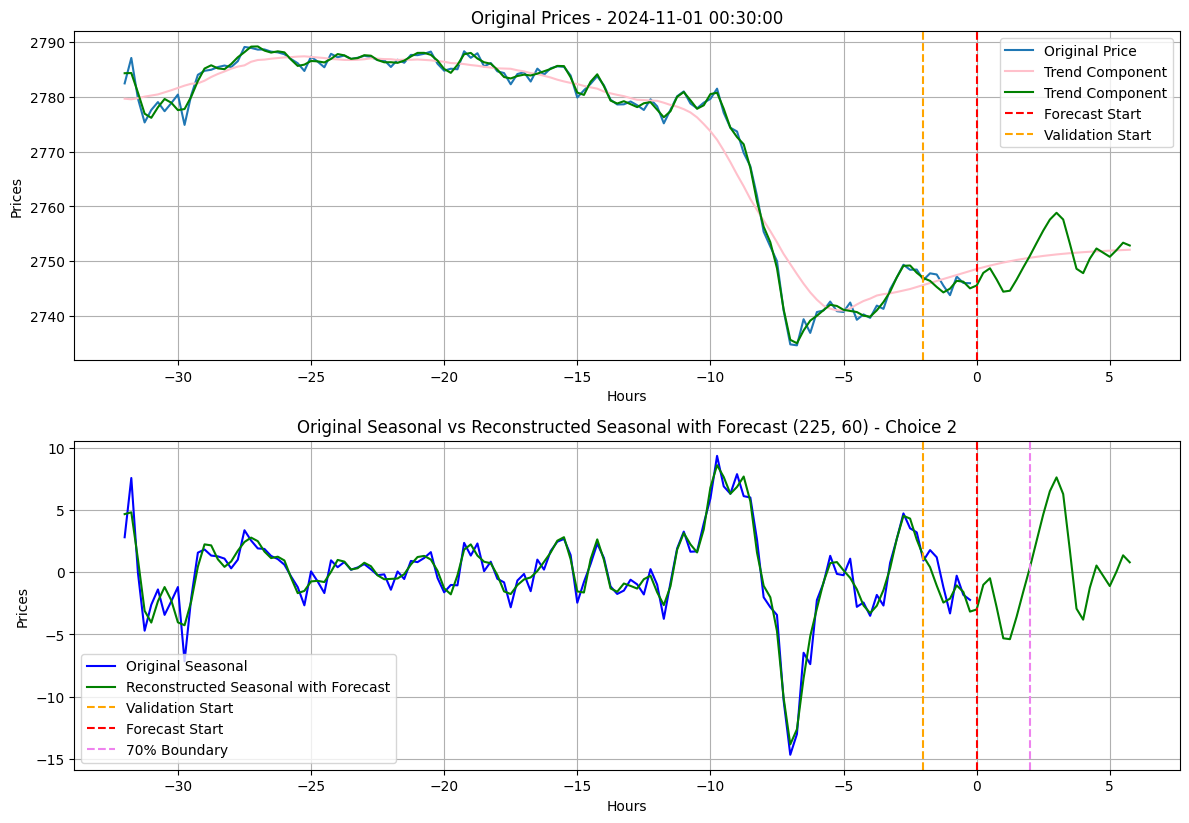

In [33]:
# Sort the dataframe first
sorted_df = results_df.sort_values(by='dtw_validation', ascending=True).reset_index(drop=True)


first_input_length = int(results_df.sort_values(by='dtw_validation', ascending=True).iloc[0]['seasonal_input_length'])
first_harmonics = int(results_df.sort_values(by='dtw_validation', ascending=True).iloc[0]['seasonal_harmonics'])

# Filter the sorted dataframe to find the first row that differs by more than 10
# Create the mask and use loc to filter
mask = (abs(sorted_df['seasonal_input_length'] - first_input_length) > 10)
next_different = sorted_df.loc[mask].iloc[0]

second_input_length = int(next_different['seasonal_input_length'])
second_harmonics = int(next_different['seasonal_harmonics'])
first_input_length
plot_forecast(first_input_length, first_harmonics, 1)
plot_forecast(second_input_length, second_harmonics, 2)